<a href="https://colab.research.google.com/github/gioodm/docking/blob/main/Lycopene_DiffDock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DiffDock
Dock a PDB files and a SMILES with [DiffDock](https://github.com/gcorso/DiffDock).

Select Runtime / Run all to run an example PDB file and SMILES.

v2 improvements:
- works on proteins >1000 aas (with flag added to extract.py)
- works on standard GPU (by reducing batch size from 10 to 6)
- works with AlphaFold ids (AF-...) as well as PDB ids
- works with comma-delimited PDB_ids and/or SMILES
- runs smina to generate affinities (as DiffDock posed, or with smina minimization)
- shows results in a py3DMol view

v3:
- fix py3dmol incompatibility
- downgrade pytorch since the colab version takes forever to install pytorch_geometric (no binary so it has to compile)
THIS MEANS YOU HAVE TO RUN ALL TWICE!

v4:
- replace smina with the more accurate gnina
- remove the annoying run twice thing now there is a binary

v5:
- add ProLIF fingerprint

colab by [@btnaughton](https://twitter.com/btnaughton)

In [ ]:
#@title PDB + SMILES input

PDB_id = 'AF-Q6C0L2-F1' #@param {type:"string"}
SMILES_or_pubchem_id = '446925' #@param {type:"string"}

#@markdown Download a tar file containing all results?
download_results = True #@param {type:"boolean"}

time: 643 µs (started: 2024-01-19 11:37:38 +00:00)


In [ ]:
# The default version of colab takes forever to install pytorch_geometric
# For now, downgrade (which requires restarting runtime :( )
#import os
#import torch
#if torch.__version__[:6] != "1.13.1":
#    !pip uninstall torch torchaudio torchdata torchtext torchvision fastai --y
#    !pip install torch==1.13.1
#    os.kill(os.getpid(), 9)

time: 330 µs (started: 2024-01-19 11:37:41 +00:00)


In [ ]:
import os
import requests
import time
from random import random

def download_pdb_file(pdb_id: str) -> str:
    """Download pdb file as a string from rcsb.org"""
    PDB_DIR ="/tmp/pdb/"
    os.makedirs(PDB_DIR, exist_ok=True)

    # url or pdb_id
    if pdb_id.startswith('http'):
        url = pdb_id
        filename = url.split('/')[-1]
    elif pdb_id.endswith(".pdb"):
        return pdb_id
    else:
        if pdb_id.startswith("AF"):
            url = f"https://alphafold.ebi.ac.uk/files/{pdb_id}-model_v3.pdb"
        else:
            url = f"http://files.rcsb.org/view/{pdb_id}.pdb"
        filename = f'{pdb_id}.pdb'

    cache_path = os.path.join(PDB_DIR, filename)
    if os.path.exists(cache_path):
        return cache_path

    pdb_req = requests.get(url)
    pdb_req.raise_for_status()
    open(cache_path, 'w').write(pdb_req.text)
    return cache_path

def download_smiles_str(pubchem_id: str, retries:int = 2) -> str:
    """Given a pubchem id, get a smiles string"""
    while True:
        req = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{pubchem_id}/property/CanonicalSMILES/CSV")
        smiles_url_csv = req.text if req.status_code == 200 else None
        if smiles_url_csv is not None:
            break
        if retries == 0:
            return None
        time.sleep(1+random())
        retries -= 1

    return smiles_url_csv.splitlines()[1].split(',')[1].strip('"').strip("'") if smiles_url_csv is not None else None

time: 1.7 ms (started: 2024-01-19 11:37:44 +00:00)


In [ ]:
if not PDB_id or not SMILES_or_pubchem_id:
    PDB_id = "6agt"
    SMILES_or_pubchem_id = "COc(cc1)ccc1C#N"
    print(f"No input supplied. Using example data: {PDB_id} and {SMILES_or_pubchem_id}")

# to run many PDB+smiles at once, fill in a list of PDB_files and smiles here...
pdb_files = [download_pdb_file(_PDB_id) for _PDB_id in PDB_id.split(",")]
smiless = [download_smiles_str(_SMILES_or_pubchem_id) if str(_SMILES_or_pubchem_id).isnumeric() else _SMILES_or_pubchem_id
           for _SMILES_or_pubchem_id in SMILES_or_pubchem_id.split(',') ]

with open("/tmp/input_protein_ligand.csv", 'w') as out:
    out.write("protein_path,ligand\n")
    for pdb_file in pdb_files:
        for smiles in smiless:
            out.write(f"{pdb_file},{smiles}\n")

time: 1.25 s (started: 2024-01-19 11:37:48 +00:00)


In [ ]:
# clear out old results if running multiple times -- hopefully they have been downloaded already
!rm -rf /content/DiffDock/results

time: 105 ms (started: 2024-01-19 11:37:51 +00:00)


## Install prerequisites

In [ ]:
!pip install ipython-autotime --quiet
%load_ext autotime

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 410 ms (started: 2024-01-19 11:37:54 +00:00)


In [ ]:
if not os.path.exists("/content/DiffDock"):
    %cd /content
    !git clone https://github.com/gcorso/DiffDock.git
    %cd /content/DiffDock
    !git checkout a6c5275 # remove/update for more up to date code

time: 541 µs (started: 2024-01-19 11:37:57 +00:00)


In [ ]:
try:
    import biopandas
except:
    !pip install pyg==0.7.1 --quiet
    !pip install pyyaml==6.0 --quiet
    !pip install scipy==1.7.3 --quiet
    !pip install networkx==2.6.3 --quiet
    !pip install biopython==1.79 --quiet
    !pip install rdkit-pypi==2022.03.5 --quiet
    !pip install e3nn==0.5.0 --quiet
    !pip install spyrmsd==0.5.2 --quiet
    !pip install pandas==1.5.3 --quiet
    !pip install biopandas==0.4.1 --quiet
    # not diffdock-specific:
    !pip install prolif --quiet # no real version??
    !pip install py3dmol==2.0.3 --quiet

time: 811 µs (started: 2024-01-19 11:38:02 +00:00)


In [ ]:
import torch
print(torch.__version__)

try:
    import torch_geometric
except ModuleNotFoundError:
    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git  --quiet # @ 15573f4674b2a37b1b9adc967df69ef6eee573ea

2.1.0+cu121
time: 3.41 ms (started: 2024-01-19 11:38:04 +00:00)


## Install ESM and prepare PDB file for ESM

In [ ]:
if not os.path.exists("/content/DiffDock/esm"):
    %cd /content/DiffDock
    !git clone https://github.com/facebookresearch/esm
    %cd /content/DiffDock/esm
    !git checkout ca8a710 # remove/update for more up to date code
    !sudo pip install -e .
    %cd /content/DiffDock

time: 590 µs (started: 2024-01-19 11:38:07 +00:00)


In [ ]:
%cd /content/DiffDock
!python datasets/esm_embedding_preparation.py --protein_ligand_csv /tmp/input_protein_ligand.csv --out_file data/prepared_for_esm.fasta

/content/DiffDock
100% 1/1 [00:00<00:00, 18.05it/s]
time: 813 ms (started: 2024-01-19 11:38:08 +00:00)


In [ ]:
%cd /content/DiffDock
%env HOME=esm/model_weights
%env PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
!python /content/DiffDock/esm/scripts/extract.py esm2_t33_650M_UR50D data/prepared_for_esm.fasta data/esm2_output --repr_layers 33 --include per_tok --truncation_seq_length 30000

/content/DiffDock
env: HOME=esm/model_weights
env: PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
Transferred model to GPU
Read data/prepared_for_esm.fasta with 1 sequences
Processing 1 of 1 batches (1 sequences)
time: 15.2 s (started: 2024-01-19 11:38:10 +00:00)


## Run DiffDock

In [ ]:
%cd /content/DiffDock
!python -m inference --protein_ligand_csv /tmp/input_protein_ligand.csv --out_dir results/user_predictions_small --inference_steps 20 --samples_per_complex 40 --batch_size 6

/content/DiffDock
Reading molecules and generating local structures with RDKit
100% 1/1 [00:00<00:00,  1.30it/s]
Reading language model embeddings.
Generating graphs for ligands and proteins
loading complexes: 100% 1/1 [00:00<00:00,  1.97it/s]
loading data from memory:  data/cache_torsion/limit0_INDEX_maxLigSizeNone_H0_recRad15.0_recMax24_esmEmbeddings3290937561/heterographs.pkl
Number of complexes:  1
radius protein: mean 79.99791717529297, std 0.0, max 79.99791717529297
radius molecule: mean 14.002159118652344, std 0.0, max 14.002159118652344
distance protein-mol: mean 14.375106811523438, std 0.0, max 14.375106811523438
rmsd matching: mean 0.0, std 0.0, max 0
HAPPENING | confidence model uses different type of graphs than the score model. Loading (or creating if not existing) the data for the confidence model now.
Reading molecules and generating local structures with RDKit
100% 1/1 [00:00<00:00,  1.18it/s]
Reading language model embeddings.
Generating graphs for ligands and proteins

# Post-process and download results

In [ ]:
%cd /content/DiffDock
!wget https://sourceforge.net/projects/smina/files/smina.static/download -O smina && chmod +x smina
!wget https://github.com/gnina/gnina/releases/download/v1.0.3/gnina -O gnina && chmod +x gnina

/content/DiffDock
--2024-01-19 11:41:23--  https://sourceforge.net/projects/smina/files/smina.static/download
Resolving sourceforge.net (sourceforge.net)... 172.64.150.145, 104.18.37.111, 2606:4700:4400::ac40:9691, ...
Connecting to sourceforge.net (sourceforge.net)|172.64.150.145|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABlql_jadZRqMpsyaIIFPuNM30GRs1DgcarquDx8TAlp_2nvG_XTRDScT9kJkskJzVDjbJYs1q-uScZqnvzQaim8K_y8w%3D%3D&use_mirror=deac-riga&r= [following]
--2024-01-19 11:41:23--  https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABlql_jadZRqMpsyaIIFPuNM30GRs1DgcarquDx8TAlp_2nvG_XTRDScT9kJkskJzVDjbJYs1q-uScZqnvzQaim8K_y8w%3D%3D&use_mirror=deac-riga&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting resp

## Run gnina to estimate affinity

In [ ]:
import re
import pandas as pd
from glob import glob
from shlex import quote
from datetime import datetime
from tqdm.auto import tqdm
from google.colab import files

%cd /content/DiffDock/results/user_predictions_small
results_dirs = glob("./index*")

rows = []
for results_dir in tqdm(results_dirs, desc="runs"):
    results_pdb_file = "/tmp/pdb/" + re.findall("tmp-pdb-(.+\.pdb)", results_dir)[0]
    results_smiles = re.findall("pdb_+(.+)", results_dir)[0]
    results_sdfs = [os.path.join(results_dir, f) for f in os.listdir(results_dir) if "confidence" in f and f.endswith(".sdf")]

    results_pdb_file_no_hetatms = f"{results_pdb_file}_nohet.pdb"
    !grep -v "^HETATM" {results_pdb_file} > {results_pdb_file_no_hetatms}
    !cp {results_pdb_file} .

    for results_sdf in tqdm(results_sdfs, leave=False, desc="files"):
        confidence = re.findall("confidence([\-\.\d]+)\.sdf", results_sdf)[0]

        scored_stdout = !/content/DiffDock/gnina --score_only -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}"
        scored_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(scored_stdout))[0]
        minimized_stdout = !/content/DiffDock/gnina --local_only --minimize -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}" --autobox_ligand "{results_sdf}" --autobox_add 2
        minimized_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(minimized_stdout))[0]

        rows.append((results_pdb_file.split('/')[-1], results_smiles, float(confidence), float(scored_affinity), float(minimized_affinity), results_sdf))

df_results = pd.DataFrame(rows, columns=["pdb_file", "smiles", "diffdock_confidence", "gnina_scored_affinity", "gnina_minimized_affinity", "sdf_file"])
df_results_tsv = "df_diffdock_results.tsv"
df_results.to_csv(df_results_tsv, sep='\t', index=None)

/content/DiffDock/results/user_predictions_small


runs:   0%|          | 0/1 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

time: 1min 12s (started: 2024-01-19 11:41:32 +00:00)


### Top hit by DiffDock confidence for any PDB/smiles combination

In [ ]:
top_hit = df_results.sort_values("diffdock_confidence", ascending=False).iloc[0]
df_results.sort_values("diffdock_confidence", ascending=False).head(3)

,pdb_file,smiles,diffdock_confidence,gnina_scored_affinity,gnina_minimized_affinity,sdf_file
0,AF-Q6C0L2-F1.pdb,CC(=CCCC(=CC=CC(=CC=CC(=CC=CC=C(C)C=CC=C(C)C=C...,-1.46,6.99703,-5.37411,./index0_-tmp-pdb-AF-Q6C0L2-F1.pdb____CC(=CCCC...
25,AF-Q6C0L2-F1.pdb,CC(=CCCC(=CC=CC(=CC=CC(=CC=CC=C(C)C=CC=C(C)C=C...,-1.51,10.93658,-2.24828,./index0_-tmp-pdb-AF-Q6C0L2-F1.pdb____CC(=CCCC...
18,AF-Q6C0L2-F1.pdb,CC(=CCCC(=CC=CC(=CC=CC(=CC=CC=C(C)C=CC=C(C)C=C...,-1.74,41.05156,-7.26554,./index0_-tmp-pdb-AF-Q6C0L2-F1.pdb____CC(=CCCC...


time: 14.9 ms (started: 2024-01-19 11:42:52 +00:00)


## Show prolif fingerprint

In [ ]:
import prolif as plf
from prolif.plotting.network import LigNetwork
from rdkit import Chem

# load protein
prot = Chem.MolFromPDBFile(top_hit.pdb_file, removeHs=False)
prot = plf.Molecule(prot)

# load ligands
lig_suppl = list(plf.sdf_supplier(top_hit.sdf_file))

# generate fingerprint
fp = plf.Fingerprint()
fp.run_from_iterable(lig_suppl, prot)

df_prolif = fp.to_dataframe() #return_atoms=True)
display(df_prolif)

prolif_fingerprint_html = "prolif_fingerprint.html"
net = LigNetwork.from_fingerprint(fp, lig_suppl[0], kind="frame", frame=0, rotation=270)
net.save(prolif_fingerprint_html)
net.display()

  0%|          | 0/1 [00:00<?, ?it/s]

ligand            UNL1                                               \
protein        GLN76.A     PHE77.A              LEU173.A   SER177.A   
interaction VdWContact Hydrophobic VdWContact VdWContact VdWContact   
Frame                                                                 
0                 True        True       True       True       True   

ligand                                                                 \
protein       SER180.A    TRP327.A   GLN328.A    HIS331.A    LEU335.A   
interaction VdWContact Hydrophobic VdWContact Hydrophobic Hydrophobic   
Frame                                                                   
0                 True        True       True        True        True   

ligand                                        
protein                  LEU439.A   LEU443.A  
interaction VdWContact VdWContact VdWContact  
Frame                                         
0                 True       True       True

time: 321 ms (started: 2024-01-19 11:42:56 +00:00)


## Create dataframe, tar file and download

In [ ]:
out_pdbs = ' '.join(set(df_results.pdb_file.apply(quote)))
out_sdfs = ' '.join(df_results.sdf_file.apply(quote))

if download_results:
    tarname = f"diffdock_{datetime.now().isoformat()[2:10].replace('-','')}"
    _ = !tar cvf {tarname}.tar --transform 's,^,{tarname}/,' --transform 's,\./,,' {out_pdbs} {out_sdfs} {df_results_tsv} {prolif_fingerprint_html}

    files.download(f"{tarname}.tar")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 123 ms (started: 2024-01-19 11:43:06 +00:00)


## Compare gnina affinities with DiffDock confidences

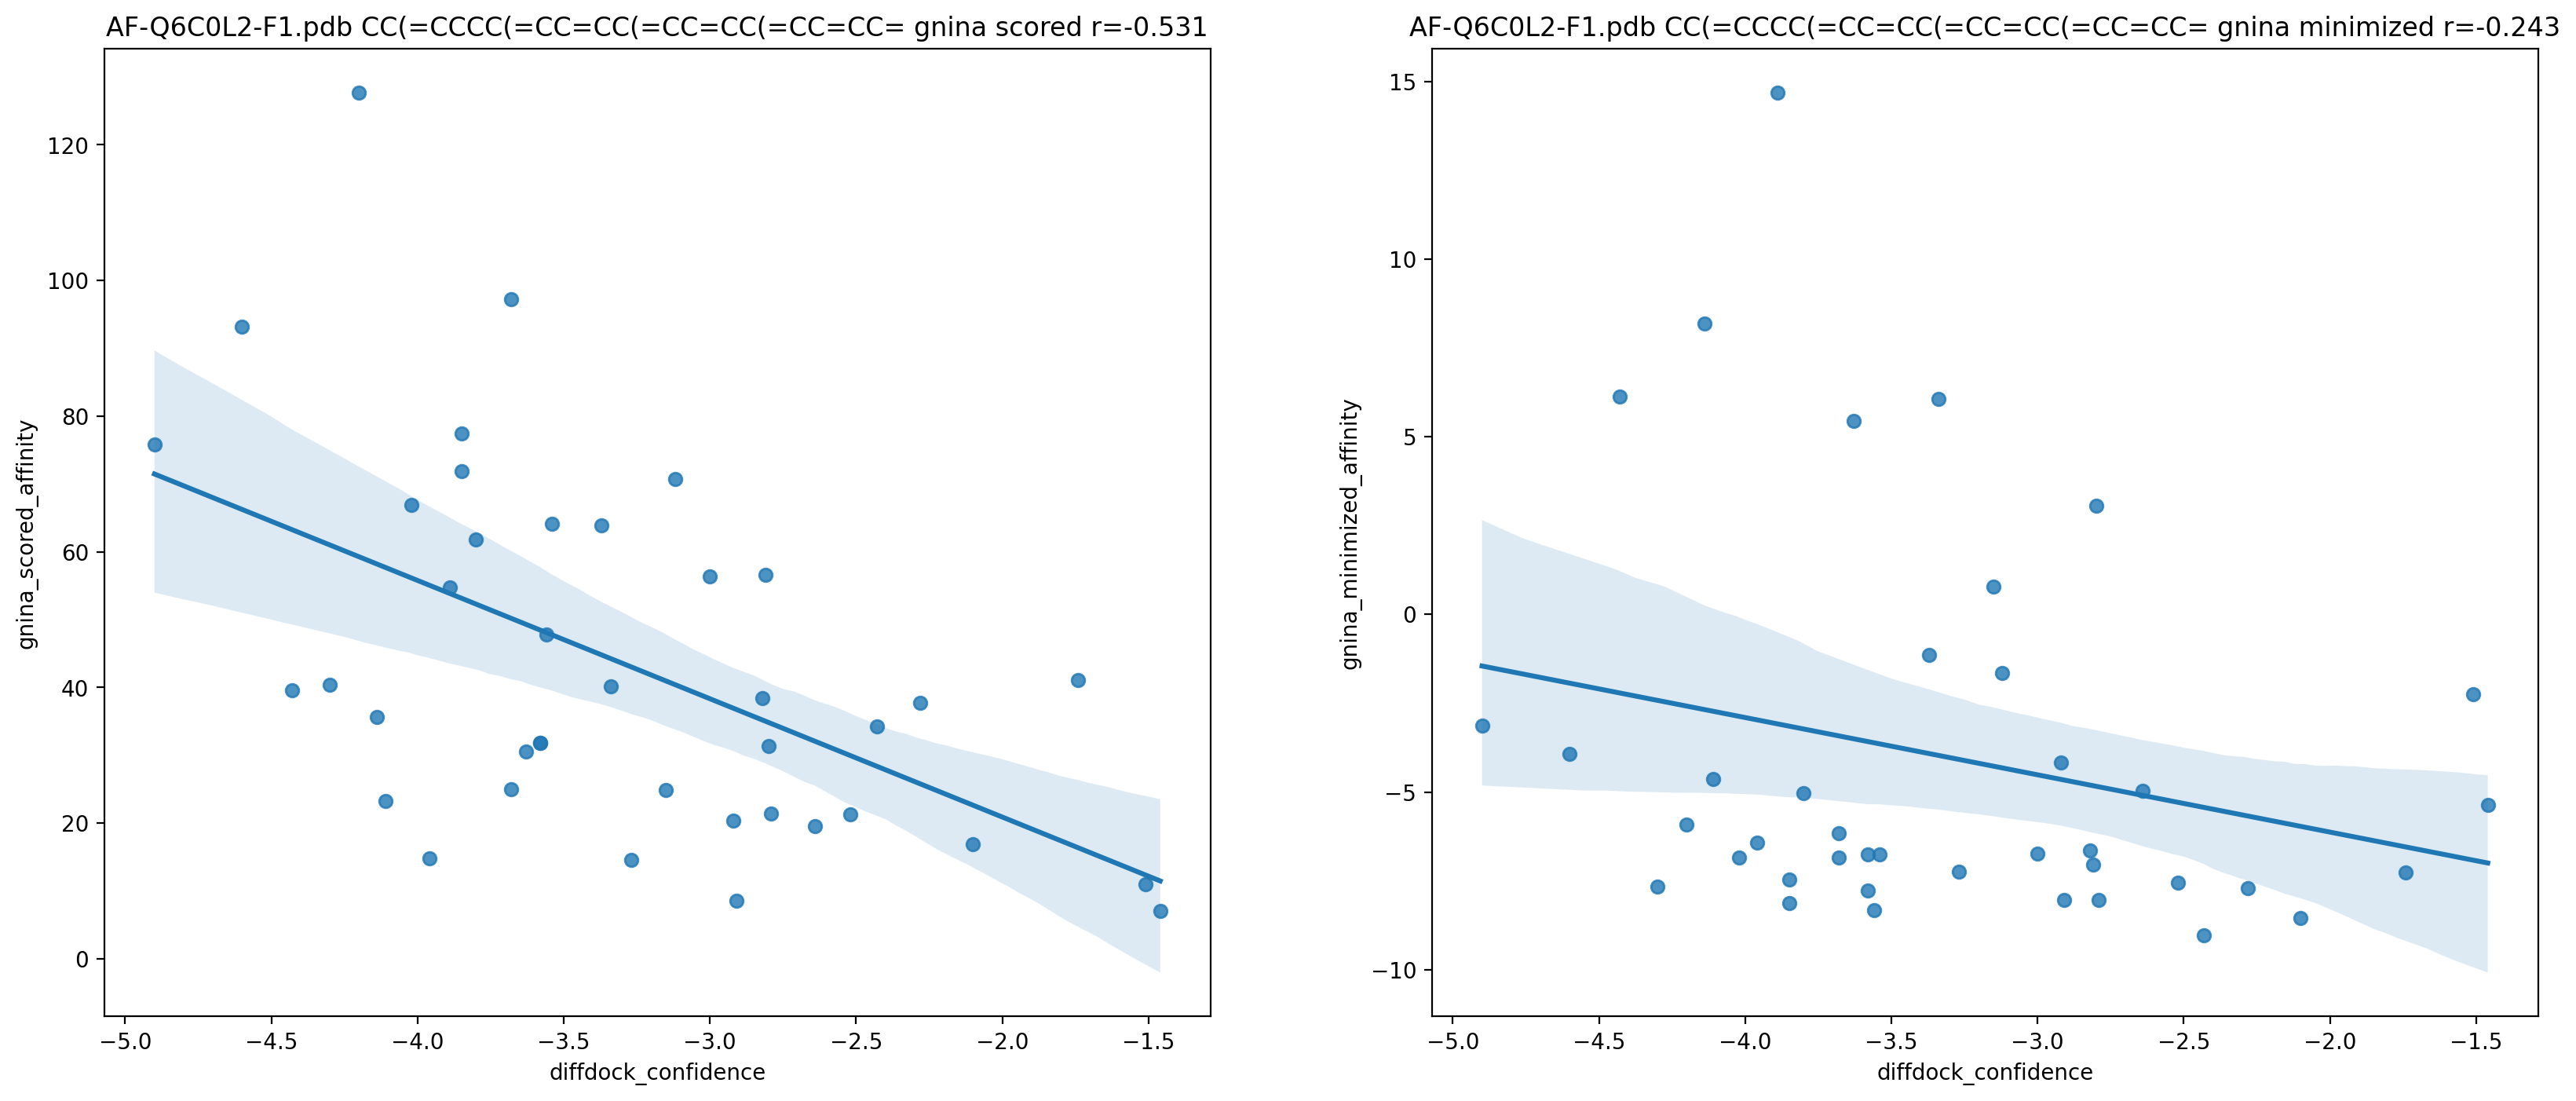

time: 1.57 s (started: 2024-01-19 11:43:32 +00:00)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
%config InlineBackend.figure_format='retina'

for (pdb_file, smiles), df_group in df_results.groupby(["pdb_file", "smiles"]):
    f, ax = plt.subplots(1, 2, figsize=(20,8))
    sns.regplot(data=df_group, x="diffdock_confidence", y="gnina_scored_affinity", ax=ax[0]);
    sns.regplot(data=df_group, x="diffdock_confidence", y="gnina_minimized_affinity", ax=ax[1]);

    slope, intercept, r_value_scored, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["gnina_scored_affinity"])
    slope, intercept, r_value_minimized, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["gnina_minimized_affinity"])
    ax[0].set_title(f"{pdb_file} {smiles[:30]} gnina scored r={r_value_scored:.3f}");
    ax[1].set_title(f"{pdb_file} {smiles[:30]} gnina minimized r={r_value_minimized:.3f}");

# Visualize top hit (highest confidence) in 3D

In [ ]:
from IPython.display import HTML
import py3Dmol

resid_hover = """
function(atom,viewer) {
    if(!atom.label) {
        atom.label = viewer.addLabel(atom.chain+" "+atom.resn+" "+atom.resi,
            {position: atom, backgroundColor: 'mintcream', fontColor:'black', fontSize:12});
    }
}"""
unhover_func = """
function(atom,viewer) {
    if(atom.label) {
        viewer.removeLabel(atom.label);
        delete atom.label;
    }
}"""

view = py3Dmol.view(width=800, height=800)
view.setCameraParameters({'fov': 35, 'z': 100});


# add sdf
view.addModel(open(top_hit.sdf_file).read(), "sdf")
view.setStyle({"model": 0}, {'stick':{"color":"#ff0000"}})
view.setViewStyle({"model": 0}, {'style':'outline','color':'black','width':0.1})
view.zoomTo();

# add surface
#view.addSurface(py3Dmol.VDW, {'opacity':0.95, 'color':'red'})

# add pdb
view.addModel(open(top_hit.pdb_file).read(), "pdb");
view.setStyle({"model": 1}, {"cartoon":{"color":"spectrum"}})
view.setStyle({"model": 1, "hetflag":True}, {'stick':{"color":"spectrum"}})

# add surface
view.addSurface(py3Dmol.VDW, {'opacity':0.95, 'color':'grey'})

model = view.getModel()
model.setHoverable({}, True, resid_hover, unhover_func)

view

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

time: 15.4 ms (started: 2024-01-19 11:44:46 +00:00)
